In [ ]:
!pip install umap-learn


In [ ]:
import umap.umap_ as umap


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [ ]:
import requests
import scipy.io.arff
import pandas as pd

url = "https://github.com/pipesanta/kr-vs-kp/raw/main/dataset_3_kr-vs-kp.arff"
file_name = "dataset_3_kr-vs-kp.arff"

# Descargar el archivo
response = requests.get(url)
response.raise_for_status() # Asegura que la descarga fue exitosa

with open(file_name, 'wb') as f:
    f.write(response.content)

# Cargar el archivo .arff
data, meta = scipy.io.arff.loadarff(file_name)

# Convertir a DataFrame de pandas
df = pd.DataFrame(data)

# Los valores de tipo string se cargan como byte strings por scipy.io.arff.loadarff.
# Es necesario decodificarlos a utf-8 para que sean strings de Python estándar
# y sean correctamente manejados por pandas y legibles para el análisis.
for col in df.select_dtypes([object]).columns:
    df[col] = df[col].str.decode('utf-8')

df.head()

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,class
0,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,t,f,t,f,f,f,...,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,t,f,...,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won


In [ ]:
# Verificar el shape del DataFrame (filas, columnas)
rows, columns = df.shape
print(f"Nuestro dataset tiene {columns} columnas y {rows} instancias")

Nuestro dataset tiene 37 columnas y 3196 instancias


In [ ]:
y = df["class"]          # etiqueta: won / nowin
X = df.drop(columns=["class"])

Esquema de particionado que voy a usar en todo el proyecto:

- Primero separo el dataset en:
  - 80 % → TRAIN (para entrenar y hacer validación cruzada)
  - 20 % → TEST (se guarda solo para la evaluación final)
- La partición es estratificada para mantener la proporción entre las clases `won` y `nowin`.

- Luego defino un `StratifiedKFold` con:
  - 10 folds
  - barajado (`shuffle=True`)
  - `random_state=42` para poder reproducir los resultados.

Este objeto `cv` es el que uso después en `GridSearchCV` para hacer la validación cruzada de todos los modelos.


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# 1) Solo separamos TRAIN (80%) y TEST (20%), estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Tamaños:")
print("Train:", X_train.shape, " - ", y_train.shape)
print("Test: ", X_test.shape,  " - ", y_test.shape)

# 2) Definimos el validador estratificado de 10 folds para usar en cross-validation
cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)

Tamaños:
Train: (2556, 36)  -  (2556,)
Test:  (640, 36)  -  (640,)


In [ ]:
print("Distribución en y completa:")
print(y.value_counts(normalize=True))

print("\nDistribución en y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en y_test:")
print(y_test.value_counts(normalize=True))

Distribución en y completa:
class
won      0.522215
nowin    0.477785
Name: proportion, dtype: float64

Distribución en y_train:
class
won      0.5223
nowin    0.4777
Name: proportion, dtype: float64

Distribución en y_test:
class
won      0.521875
nowin    0.478125
Name: proportion, dtype: float64


Para poder entrenar los modelos, primero se necesita convertir todas las variables categóricas en una representación numérica. En este caso, como todas las columnas de entrada son categóricas,se construye un ColumnTransformer que aplica un OneHotEncoder sobre todas ellas. El OneHotEncoder crea columnas binarias (0/1) por cada categoría posible y handle_unknown="ignore" hace que el modelo no falle si en el conjunto de prueba aparece alguna categoría nueva que no estaba en el entrenamiento. Este preprocesador (preprocess) luego se conecta al clasificador dentro del Pipeline.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Todas las columnas de entrada son categóricas
categorical_features = X_train.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

Se definen 5 modelos de clasificación dentro de pipelines: regresión logística, árbol de decisión, random forest, red neuronal MLP y SVM con kernel RBF.
En todos los casos primero se aplica el mismo preprocesamiento (preprocess) y luego el clasificador correspondiente.
Para cada modelo se especifica una rejilla de hiperparámetros (param_grid) con distintos valores (por ejemplo C, max_depth, n_estimators, hidden_layer_sizes, gamma, etc.) que se usarán después en una búsqueda de hiperparámetros.
Finalmente, se agrupan los pipelines y sus rejillas en el diccionario models para poder probar y comparar fácilmente todos los modelos.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# 1. Regresión logística (modelo paramétrico)
pipe_logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="lbfgs"          # fijo, como se describe en el informe
    ))
])

param_grid_logreg = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__class_weight": [None, "balanced"]
}

# 2. Árbol de decisión (modelo no paramétrico)
pipe_tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid_tree = {
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 10, 20],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__criterion": ["gini", "entropy"]
}

# 3. Random Forest (ensamble de árboles de decisión)
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1                # opcional, solo para acelerar
    ))
])

param_grid_rf = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__max_features": ["sqrt", "log2"],
    "clf__min_samples_leaf": [1, 2, 4]
}

# 4. Red neuronal artificial (MLP)
pipe_mlp = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", MLPClassifier(
        max_iter=500,
        random_state=42
    ))
])

param_grid_mlp = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "clf__activation": ["relu", "tanh"],
    "clf__alpha": [0.0001, 0.001, 0.01],
    "clf__learning_rate_init": [0.001, 0.01]
}

# 5. SVM con kernel RBF
pipe_svm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", SVC(
        kernel="rbf"            # fijo, tal como se menciona en el informe
    ))
])

param_grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.001]
}

models = {
    "logreg": (pipe_logreg, param_grid_logreg),
    "tree": (pipe_tree, param_grid_tree),
    "rf": (pipe_rf, param_grid_rf),
    "mlp": (pipe_mlp, param_grid_mlp),
    "svm": (pipe_svm, param_grid_svm),
}


Se realiza una búsqueda de hiperparámetros con GridSearchCV para cada uno de los modelos definidos en models, usando validación cruzada estratificada (cv) y dos métricas: f1_macro (principal, usada para elegir el mejor modelo con refit="f1_macro") y accuracy.
Para cada modelo se entrena el GridSearch, se guarda el mejor estimador reentrenado en el diccionario mejores_modelos y se extraen, de cv_results_, las métricas promedio y desviación estándar de F1-macro y accuracy correspondientes a la mejor combinación de hiperparámetros.
Con esa información se construye una lista de diccionarios resultados_cv que incluye el nombre del modelo, los mejores hiperparámetros y las métricas de validación cruzada, y finalmente se convierte en un DataFrame (df_resultados_cv) para visualizar y comparar los resultados de todos los modelos.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

resultados_cv = []
mejores_modelos = {}

for name, (pipe, param_grid) in models.items():
    print(f"=== Entrenando modelo: {name} ===")

    # GridSearchCV con dos métricas: f1_macro (principal) y accuracy
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring={
            "f1_macro": "f1_macro",
            "accuracy": "accuracy"
        },
        refit="f1_macro",     # el mejor modelo se elige por F1-macro
        cv=cv,                # StratifiedKFold(10, shuffle=True, random_state=42)
        n_jobs=-1,
        return_train_score=True
    )

    grid.fit(X_train, y_train)

    # Mejor modelo ya reentrenado sobre TODO el TRAIN (80%)
    best_model = grid.best_estimator_
    mejores_modelos[name] = best_model

    # Índice de la mejor combinación de hiperparámetros
    best_idx = grid.best_index_

    # Métricas de validación cruzada (promedio y desviación estándar)
    mean_f1 = grid.cv_results_["mean_test_f1_macro"][best_idx]
    std_f1  = grid.cv_results_["std_test_f1_macro"][best_idx]
    mean_acc = grid.cv_results_["mean_test_accuracy"][best_idx]
    std_acc  = grid.cv_results_["std_test_accuracy"][best_idx]

    resultados_cv.append({
        "modelo": name,
        "mejores_hiperparametros": grid.best_params_,
        "mean_f1_macro_cv": mean_f1,
        "std_f1_macro_cv": std_f1,
        "mean_accuracy_cv": mean_acc,
        "std_accuracy_cv": std_acc
    })

df_resultados_cv = pd.DataFrame(resultados_cv)
df_resultados_cv


=== Entrenando modelo: logreg ===
=== Entrenando modelo: tree ===
=== Entrenando modelo: rf ===
=== Entrenando modelo: mlp ===
=== Entrenando modelo: svm ===


,modelo,mejores_hiperparametros,mean_f1_macro_cv,std_f1_macro_cv,mean_accuracy_cv,std_accuracy_cv
0,logreg,"{'clf__C': 100, 'clf__class_weight': 'balanced'}",0.971786,0.014191,0.971846,0.014161
1,tree,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.995296,0.002353,0.995306,0.002347
2,rf,"{'clf__max_depth': 20, 'clf__max_features': 's...",0.990199,0.005331,0.990224,0.005313
3,mlp,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",0.995687,0.002743,0.995695,0.002738
4,svm,"{'clf__C': 10, 'clf__gamma': 'scale'}",0.994909,0.004966,0.994917,0.004958


Se selecciona el mejor modelo según el F1-macro promedio en validación cruzada, tomando la primera fila de df_resultados_cv ordenado de forma descendente por mean_f1_macro_cv.
A partir de esa fila se obtiene el nombre del modelo (mejor_nombre), se muestran por pantalla el modelo ganador y sus mejores hiperparámetros, y luego se recupera el objeto correspondiente desde el diccionario mejores_modelos (ya reentrenado con todo el conjunto de entrenamiento, el 80%).

Con ese modelo final se genera la predicción sobre el conjunto de test (X_test) y se calculan las métricas finales: accuracy, f1_macro, precision_macro y recall_macro, además de la matriz de confusión (cm_test).
Por último, se imprimen en consola todas estas métricas y la matriz de confusión para evaluar el desempeño del mejor modelo sobre el 20% de datos retenidos para prueba.

In [ ]:
from sklearn.metrics import confusion_matrix

# Elegimos el modelo con mejor F1-macro en validación cruzada
mejor_fila = df_resultados_cv.sort_values(
    "mean_f1_macro_cv",
    ascending=False
).iloc[0]

mejor_nombre = mejor_fila["modelo"]

print("Mejor modelo según F1-macro en CV:", mejor_nombre)
print("Mejores hiperparámetros:", mejor_fila["mejores_hiperparametros"])

# Recuperamos el mejor modelo ya reentrenado sobre TODO el TRAIN (80%)
best_model = mejores_modelos[mejor_nombre]

# Evaluación final en TEST (20%)
y_pred_test = best_model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average="macro")
prec_test = precision_score(y_test, y_pred_test, average="macro")
rec_test = recall_score(y_test, y_pred_test, average="macro")
cm_test = confusion_matrix(y_test, y_pred_test)

print("\nDesempeño final en TEST (20% retenido):")
print("Accuracy:", acc_test)
print("F1 macro:", f1_test)
print("Precision macro:", prec_test)
print("Recall macro:", rec_test)
print("\nMatriz de confusión:\n", cm_test)


Mejor modelo según F1-macro en CV: mlp
Mejores hiperparámetros: {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001}

Desempeño final en TEST (20% retenido):
Accuracy: 0.9953125
F1 macro: 0.9953041423823161
Precision macro: 0.9952411695082705
Recall macro: 0.9953720010958476

Matriz de confusión:
 [[305   1]
 [  2 332]]


Se seleccionan solo las columnas más relevantes del resumen de validación cruzada (df_resultados_cv): nombre del modelo y las métricas promedio y desviación estándar de F1-macro y accuracy.
Con esas columnas se crea ranking_cv, ordenando las filas de forma descendente según mean_f1_macro_cv (mejor F1-macro primero) y reiniciando los índices.
El resultado es una tabla ordenada que muestra el ranking de modelos en validación cruzada según su F1-macro promedio.


In [ ]:
# Columnas que nos interesan del resumen de CV
cols = [
    "modelo",
    "mean_f1_macro_cv",
    "std_f1_macro_cv",
    "mean_accuracy_cv",
    "std_accuracy_cv"
]

# Ordenar por F1-macro promedio (de mayor a menor)
ranking_cv = (
    df_resultados_cv[cols]
    .sort_values("mean_f1_macro_cv", ascending=False)
    .reset_index(drop=True)
)

ranking_cv


,modelo,mean_f1_macro_cv,std_f1_macro_cv,mean_accuracy_cv,std_accuracy_cv
0,mlp,0.995687,0.002743,0.995695,0.002738
1,tree,0.995296,0.002353,0.995306,0.002347
2,svm,0.994909,0.004966,0.994917,0.004958
3,rf,0.990199,0.005331,0.990224,0.005313
4,logreg,0.971786,0.014191,0.971846,0.014161


Se construye una tabla resumida de resultados a partir de df_resultados_cv, quedándose solo con las columnas: nombre del modelo, accuracy promedio en CV y F1-macro promedio en CV.
Esa tabla (tabla_x) se ordena de mayor a menor según mean_f1_macro_cv y se reinician los índices. Luego se crea una copia (tabla_x_rounded) donde las métricas numéricas (todas las columnas excepto "modelo") se redondean a 4 decimales para facilitar la presentación de los resultados.

In [ ]:
# Columnas que queremos para la tabla de resultados
cols_tabla_x = [
    "modelo",
    "mean_accuracy_cv",
    "mean_f1_macro_cv"
]

# Filtrar y ordenar por F1-macro promedio (de mayor a menor)
tabla_x = (
    df_resultados_cv[cols_tabla_x]
    .sort_values("mean_f1_macro_cv", ascending=False)
    .reset_index(drop=True)
)

# Redondear a 4 decimales para presentación
tabla_x_rounded = tabla_x.copy()
for c in tabla_x_rounded.columns[1:]:
    tabla_x_rounded[c] = tabla_x_rounded[c].round(4)

tabla_x_rounded


,modelo,mean_accuracy_cv,mean_f1_macro_cv
0,mlp,0.9957,0.9957
1,tree,0.9953,0.9953
2,svm,0.9949,0.9949
3,rf,0.9902,0.9902
4,logreg,0.9718,0.9718


Se prepara una copia de X (X_codes) y se convierten todas sus columnas a tipo categórico con códigos enteros, para poder trabajar cómodamente con mutual_info_classif.
Luego se calcula la información mutua entre cada feature y la variable objetivo y, asumiendo que todas las características son discretas (discrete_features=True).
Con esos valores se arma un DataFrame (mi_df) que contiene el nombre de cada feature y su información mutua, se ordena de mayor a menor (mi_df_sorted) y se redondean los valores a 4 decimales para facilitar la visualización de qué variables aportan más información sobre la clase.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# Copiamos X y convertimos cada columna categórica a códigos enteros
X_codes = X.copy()

for col in X_codes.columns:
    X_codes[col] = X_codes[col].astype("category").cat.codes

# Calculamos la información mutua entre cada feature y la clase
mi = mutual_info_classif(
    X_codes,
    y,
    discrete_features=True,
    random_state=42
)

# Armamos un DataFrame con los resultados
mi_df = pd.DataFrame({
    "feature": X_codes.columns,
    "mutual_info": mi
})

# Ordenamos de mayor a menor información mutua
mi_df_sorted = mi_df.sort_values("mutual_info", ascending=False).reset_index(drop=True)

# Redondeamos para visualización
mi_df_sorted["mutual_info"] = mi_df_sorted["mutual_info"].round(4)

mi_df_sorted


,feature,mutual_info
0,rimmx,0.1374
1,bxqsq,0.0748
2,wknck,0.0683
3,bkxwp,0.0276
4,katri,0.0255
5,wkna8,0.0215
6,r2ar8,0.0137
7,bkxcr,0.0135
8,mulch,0.0134
9,stlmt,0.0110


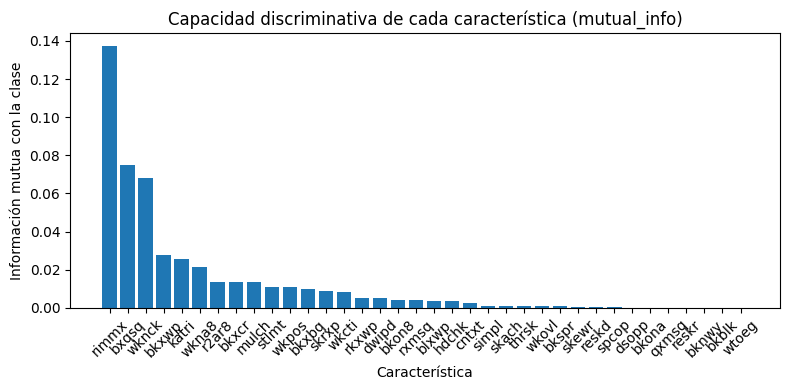

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(mi_df_sorted["feature"], mi_df_sorted["mutual_info"])
plt.xticks(rotation=45)
plt.ylabel("Información mutua con la clase")
plt.xlabel("Característica")
plt.title("Capacidad discriminativa de cada característica (mutual_info)")
plt.tight_layout()
plt.show()


Se utiliza el ranking de información mutua (mi_df_sorted) para ordenar las variables de menor a mayor importancia y, a partir de ahí, se prueban distintos niveles de reducción de dimensionalidad eliminando las k características menos informativas (ks = [4, 8, 12, 16]).

Para cada valor de k:

Se determinan las variables a eliminar (features_drop) y las que se conservan (features_keep).

Se generan subconjuntos reducidos de X_train, X_val y X_test solo con features_keep.

Se define un nuevo ColumnTransformer (preprocess_red) que aplica OneHotEncoder únicamente sobre esas variables.

Se construye un nuevo Pipeline (pipe_tree_red) con ese preprocesamiento reducido y un DecisionTreeClassifier con hiperparámetros fijos.

Se entrena el modelo con la unión de train y val (X_trainval_red, y_trainval_red) y se evalúa en el conjunto de test reducido (X_test_red), calculando accuracy y f1_macro.

Finalmente, los resultados para cada nivel de recorte (número de características eliminadas y métricas en test) se guardan en la lista resultados_dim y se muestran agrupados en un DataFrame para comparar cómo afecta la eliminación de variables al desempeño del modelo.

In [ ]:
# Tomamos el ranking de MI que ya calculaste
# mi_df_sorted: columnas ["feature", "mutual_info"]

# Lista de features en orden de menor a mayor importancia
least_to_most = mi_df_sorted.sort_values("mutual_info", ascending=True)["feature"].tolist()

# Distintos niveles de recorte que quieres probar
ks = [4, 8, 12, 16]   # por ejemplo

from copy import deepcopy

resultados_dim = []

for k in ks:
    features_drop = least_to_most[:k]   # las k menos informativas
    features_keep = [f for f in X.columns if f not in features_drop]

    print(f"\n=== Probando eliminando {k} características: {features_drop} ===")

    # Subconjuntos reducidos
    X_train_red = X_train[features_keep]
    X_val_red   = X_val[features_keep]
    X_test_red  = X_test[features_keep]

    # Reusamos el mismo preprocess pero SOLO con estas columnas
    preprocess_red = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), features_keep)
        ]
    )

    # Clonamos el mejor modelo base (árbol) pero con el nuevo preprocess
    from sklearn.tree import DecisionTreeClassifier
    pipe_tree_red = Pipeline(steps=[
        ("preprocess", preprocess_red),
        ("clf", DecisionTreeClassifier(
            criterion="entropy",
            max_depth=None,
            min_samples_leaf=1,
            min_samples_split=2,
            random_state=42
        ))
    ])

    # Entrenamos con train + val (igual que con el modelo final)
    X_trainval_red = pd.concat([X_train_red, X_val_red], axis=0)
    y_trainval_red = pd.concat([y_train, y_val], axis=0)

    pipe_tree_red.fit(X_trainval_red, y_trainval_red)

    y_pred_test_red = pipe_tree_red.predict(X_test_red)

    acc = accuracy_score(y_test, y_pred_test_red)
    f1  = f1_score(y_test, y_pred_test_red, average="macro")

    print(f"Accuracy test con {k} eliminadas: {acc:.4f}")
    print(f"F1 macro test con {k} eliminadas: {f1:.4f}")

    resultados_dim.append({
        "k_eliminadas": k,
        "accuracy_test": acc,
        "f1_macro_test": f1
    })

pd.DataFrame(resultados_dim)



=== Probando eliminando 4 características: ['wtoeg', 'bkblk', 'bknwy', 'reskr'] ===
Accuracy test con 4 eliminadas: 0.9781
F1 macro test con 4 eliminadas: 0.9781

=== Probando eliminando 8 características: ['wtoeg', 'bkblk', 'bknwy', 'reskr', 'dsopp', 'bkona', 'qxmsq', 'spcop'] ===
Accuracy test con 8 eliminadas: 0.9641
F1 macro test con 8 eliminadas: 0.9640

=== Probando eliminando 12 características: ['wtoeg', 'bkblk', 'bknwy', 'reskr', 'dsopp', 'bkona', 'qxmsq', 'spcop', 'reskd', 'skewr', 'wkovl', 'thrsk'] ===
Accuracy test con 12 eliminadas: 0.9641
F1 macro test con 12 eliminadas: 0.9640

=== Probando eliminando 16 características: ['wtoeg', 'bkblk', 'bknwy', 'reskr', 'dsopp', 'bkona', 'qxmsq', 'spcop', 'reskd', 'skewr', 'wkovl', 'thrsk', 'bkspr', 'skach', 'simpl', 'cntxt'] ===
Accuracy test con 16 eliminadas: 0.9609
F1 macro test con 16 eliminadas: 0.9609


,k_eliminadas,accuracy_test,f1_macro_test
0,4,0.978125,0.978089
1,8,0.964063,0.963978
2,12,0.964063,0.964016
3,16,0.960938,0.960868


Se define un preprocesamiento basado en OneHotEncoder aplicado a todas las columnas categóricas de X_train (en este caso, simplemente todas las columnas).
Para ello se crea un ColumnTransformer llamado preprocess_dense que aplica OneHotEncoder con handle_unknown="ignore" y sparse_output=False para obtener una matriz densa.

Luego, se ajusta este transformador con los datos de entrenamiento (fit_transform sobre X_train) y se aplica la misma transformación al conjunto de test (transform sobre X_test), generando X_train_ohe y X_test_ohe en formato one-hot.
Finalmente, se imprimen las formas (shape) del TRAIN original y del TRAIN transformado para ver cuántas columnas nuevas se generaron tras la codificación one-hot.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = X_train.columns.tolist()

preprocess_dense = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False  # si da error, usa: sparse=False
            ),
            categorical_features
        )
    ]
)

# Ajustamos en TRAIN y transformamos
X_train_ohe = preprocess_dense.fit_transform(X_train)
X_test_ohe  = preprocess_dense.transform(X_test)

print("Shape original (TRAIN):", X_train.shape)
print("Shape one-hot (TRAIN):", X_train_ohe.shape)


Shape original (TRAIN): (2556, 36)
Shape one-hot (TRAIN): (2556, 73)


Se aplica PCA sobre los datos ya codificados en one-hot (X_train_ohe) para reducir la dimensionalidad, indicando n_components=0.95 para conservar el 95% de la varianza total.
Se ajusta el PCA con el conjunto de entrenamiento (fit_transform en X_train_ohe) y luego se proyecta el conjunto de test (transform en X_test_ohe), obteniendo X_train_pca y X_test_pca en el nuevo espacio de componentes principales.
Por último, se imprimen las dimensiones antes y después de PCA, el número de componentes retenidos y la suma de la varianza explicada, para verificar cuánta información se conserva tras la reducción de dimensionalidad.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# PCA reteniendo el 95% de la varianza
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_ohe)
X_test_pca  = pca.transform(X_test_ohe)

print("Shape one-hot (TRAIN):", X_train_ohe.shape)
print("Shape tras PCA (TRAIN):", X_train_pca.shape)
print("Número de componentes retenidos:", pca.n_components_)
print("Varianza total explicada:", pca.explained_variance_ratio_.sum())


Shape one-hot (TRAIN): (2556, 73)
Shape tras PCA (TRAIN): (2556, 24)
Número de componentes retenidos: 24
Varianza total explicada: 0.9511493343581573


Se calcula la varianza explicada acumulada de los componentes del PCA (np.cumsum(...)) y se arma un DataFrame con el número de componente y su varianza acumulada asociada.
Luego se redondean esos valores a 4 decimales para visualizar mejor cómo va creciendo la varianza explicada a medida que se incorporan más componentes.

In [ ]:
varianza_acum = np.cumsum(pca.explained_variance_ratio_)

df_pca = pd.DataFrame({
    "componente": np.arange(1, pca.n_components_ + 1),
    "varianza_acumulada": varianza_acum
})

df_pca["varianza_acumulada"] = df_pca["varianza_acumulada"].round(4)

df_pca


,componente,varianza_acumulada
0,1,0.1411
1,2,0.2541
2,3,0.3487
3,4,0.4152
4,5,0.4769
5,6,0.5318
6,7,0.5786
7,8,0.6219
8,9,0.6594
9,10,0.6943


Se define una clase UMAPUnsup que hereda de UMAP y TransformerMixin para poder usar UMAP dentro de un Pipeline de sklearn en modo no supervisado.
En los métodos fit y fit_transform se ignora el parámetro y (se fuerza a None), pero se permiten argumentos extra (*args, **kwargs), de manera que UMAP solo tenga en cuenta X al ajustar y transformar.

In [ ]:
from umap import UMAP
from sklearn.base import TransformerMixin

class UMAPUnsup(UMAP, TransformerMixin):
    """
    Versión no supervisada de UMAP para usar en Pipeline.
    Ignora y, pero acepta argumentos extra que UMAP interno pueda pasar.
    """
    def fit(self, X, y=None, *args, **kwargs):
        # Forzamos y=None pero dejamos pasar el resto de args/kwargs
        return super().fit(X, None, *args, **kwargs)

    def fit_transform(self, X, y=None, *args, **kwargs):
        # Ídem para fit_transform
        return super().fit_transform(X, None, *args, **kwargs)

numero de dimension a las que va a reducir el numero de caracteristicas originales

In [ ]:
n_components_umap = 10

Se estima primero cuántas columnas tendría el dataset después de aplicar one-hot encoding completo (n_original).
Luego, usando n_components_umap (dimensión reducida de UMAP), se calcula el porcentaje de reducción de dimensionalidad y se imprime: dimensión original one-hot, dimensión final con UMAP y el porcentaje de reducción logrado.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Estimar dimensionalidad original tras one-hot (solo para el cálculo de reducción)
oh = OneHotEncoder(handle_unknown="ignore")
X_oh = oh.fit_transform(X)
n_original = X_oh.shape[1]

reduccion_porcentaje = 100.0 * (1 - n_components_umap / n_original)
print("Dimensión original (one-hot):", n_original)
print("Dimensión UMAP:", n_components_umap)
print("Reducción de dimensión: %.2f%%" % reduccion_porcentaje)


Dimensión original (one-hot): 73
Dimensión UMAP: 10
Reducción de dimensión: 86.30%


Se construye un Pipeline (pipe_tree_umap) que primero aplica el preprocesado original (preprocess), luego reduce la dimensionalidad con UMAPUnsup (a n_components_umap dimensiones, con n_neighbors=15 y min_dist=0.1) y finalmente entrena un DecisionTreeClassifier.
Además, se define param_grid_tree_umap con algunos hiperparámetros del árbol (max_depth y min_samples_leaf) para poder ajustar y evaluar este modelo con reducción de dimensión mediante búsqueda de hiperparámetros.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_tree_umap = Pipeline(steps=[
    ("preprocess", preprocess),
    ("umap", UMAPUnsup(
        n_components=n_components_umap,
        random_state=42,
        n_neighbors=15,
        min_dist=0.1
    )),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid_tree_umap = {
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 4]
}


Se define un Pipeline (pipe_mlp_umap) que aplica el preprocesamiento (preprocess), luego reduce la dimensionalidad con UMAPUnsup (usando n_components_umap, n_neighbors=15 y min_dist=0.1) y finalmente entrena un MLPClassifier con hasta 500 iteraciones.
Además, se fija una rejilla de hiperparámetros (param_grid_mlp_umap) para la red MLP (tamaños de capas ocultas, activación, alpha y tasa de aprendizaje inicial) para poder hacer búsqueda de hiperparámetros en este modelo con UMAP.

In [ ]:
from sklearn.neural_network import MLPClassifier

pipe_mlp_umap = Pipeline(steps=[
    ("preprocess", preprocess),
    ("umap", UMAPUnsup(
        n_components=n_components_umap,
        random_state=42,
        n_neighbors=15,
        min_dist=0.1
    )),
    ("clf", MLPClassifier(max_iter=500, random_state=42))
])

param_grid_mlp_umap = {
    "clf__hidden_layer_sizes": [(50,), (100,)],
    "clf__activation": ["relu"],
    "clf__alpha": [0.0001, 0.001],
    "clf__learning_rate_init": [0.001]
}


In [ ]:
models_umap = {
    "tree_umap": (pipe_tree_umap, param_grid_tree_umap),
    "mlp_umap": (pipe_mlp_umap, param_grid_mlp_umap),
}


Se realiza una búsqueda de hiperparámetros con GridSearchCV para cada modelo que incluye UMAP (models_umap), usando validación cruzada con dos métricas: f1_macro (para elegir el mejor modelo con refit="f1_macro") y accuracy.
Para cada modelo se entrena el GridSearch, se guarda el mejor estimador en mejores_modelos_umap y se extraen, de cv_results_, las medias y desviaciones estándar de F1-macro y accuracy asociadas a la mejor combinación de hiperparámetros.
Con esa información se arma la lista resultados_cv_umap, que luego se convierte en el DataFrame df_resultados_cv_umap para resumir y comparar el rendimiento de los modelos que usan UMAP.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

resultados_cv_umap = []
mejores_modelos_umap = {}

for name, (pipe, param_grid) in models_umap.items():
    print(f"=== Entrenando modelo (UMAP): {name} ===")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring={
            "f1_macro": "f1_macro",
            "accuracy": "accuracy"
        },
        refit="f1_macro",
        cv=cv,                # StratifiedKFold(10, shuffle=True, random_state=42)
        n_jobs=-1,
        return_train_score=True,
        verbose=2
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    mejores_modelos_umap[name] = best_model

    best_idx  = grid.best_index_
    mean_f1   = grid.cv_results_["mean_test_f1_macro"][best_idx]
    std_f1    = grid.cv_results_["std_test_f1_macro"][best_idx]
    mean_acc  = grid.cv_results_["mean_test_accuracy"][best_idx]
    std_acc   = grid.cv_results_["std_test_accuracy"][best_idx]

    resultados_cv_umap.append({
        "modelo": name,
        "mejores_hiperparametros": grid.best_params_,
        "mean_f1_macro_cv": mean_f1,
        "std_f1_macro_cv": std_f1,
        "mean_accuracy_cv": mean_acc,
        "std_accuracy_cv": std_acc
    })

df_resultados_cv_umap = pd.DataFrame(resultados_cv_umap)
df_resultados_cv_umap


=== Entrenando modelo (UMAP): tree_umap ===
Fitting 10 folds for each of 9 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


=== Entrenando modelo (UMAP): mlp_umap ===
Fitting 10 folds for each of 4 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,modelo,mejores_hiperparametros,mean_f1_macro_cv,std_f1_macro_cv,mean_accuracy_cv,std_accuracy_cv
0,tree_umap,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.787047,0.027625,0.787174,0.027713
1,mlp_umap,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",0.739527,0.023258,0.742569,0.020812


In [ ]:
# Agregar porcentaje de reducción (es el mismo para ambos modelos)
df_resultados_cv_umap["reduccion_dim_pct"] = reduccion_porcentaje

# Redondear para presentación
df_tabla_umap = df_resultados_cv_umap[[
    "modelo",
    "mean_accuracy_cv",
    "std_accuracy_cv",
    "mean_f1_macro_cv",
    "std_f1_macro_cv",
    "reduccion_dim_pct",
    "mejores_hiperparametros"
]].copy()

for col in ["mean_accuracy_cv", "std_accuracy_cv", "mean_f1_macro_cv", "std_f1_macro_cv", "reduccion_dim_pct"]:
    df_tabla_umap[col] = df_tabla_umap[col].round(4)

df_tabla_umap


,modelo,mean_accuracy_cv,std_accuracy_cv,mean_f1_macro_cv,std_f1_macro_cv,reduccion_dim_pct,mejores_hiperparametros
0,tree_umap,0.7872,0.0277,0.7870,0.0276,86.3014,"{'clf__max_depth': None, 'clf__min_samples_lea..."
1,mlp_umap,0.7426,0.0208,0.7395,0.0233,86.3014,"{'clf__activation': 'relu', 'clf__alpha': 0.00..."
